# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

### Not for Grading


#### Multiclass Text classification

The objective of this experiment is to learn how PCA effects the classification accuracy

We will be using a dataset that consists of nearly 20000 messages taken from 20 newsgroups. A news group is like a discussion forum and a message is a post in such a forum. You can read more about Usenet newsgroups here:  https://en.wikipedia.org/wiki/Usenet_newsgroup. Please skim that article for now and read it leisurely *after* or *before* the experiment :-)

### Datasource
http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P19A06E_test" #@param {type:"string"}

In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "981234567" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M1W2_CS_2_PCA_for_Classification" #name of the notebook
Answer = "Ungraded"
def setup():
    ipython.magic("sx pip3 install gensim")
    ipython.magic("sx wget https://www.dropbox.com/s/co7acc5qt71tao2/AIML_DS_NEWSGROUPS_PICKELFILE.pkl.zip?dl=1")
    ipython.magic("sx unzip AIML_DS_NEWSGROUPS_PICKELFILE.pkl.zip?dl=1")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", r["date"])
      print("Time of submission: ", r["time"])
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getAnswer():
  try:
    return Answer
  except NameError:
    print ("Please answer Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
    from IPython.display import HTML
    HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id))
  
else:
  print ("Please complete Id and Password cells before running setup")


Setup completed successfully


In [0]:
# Importing required Packages
import pickle
import re
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Loading the dataset

dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(type(dataset))
print(dataset.keys())

<class 'dict'>
dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [0]:
# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
for key in dataset:
    print(key, ':', len(dataset[key]))

Class : count
--------------
talk.politics.mideast : 940
rec.autos : 990
comp.sys.mac.hardware : 961
alt.atheism : 799
rec.sport.baseball : 994
comp.os.ms-windows.misc : 985
rec.sport.hockey : 999
sci.crypt : 991
sci.med : 990
talk.politics.misc : 775
rec.motorcycles : 994
comp.windows.x : 980
comp.graphics : 973
comp.sys.ibm.pc.hardware : 982
sci.electronics : 981
talk.politics.guns : 910
sci.space : 987
soc.religion.christian : 997
misc.forsale : 972
talk.religion.misc : 628


Next, let us split our dataset which consists of  about 1000 samples per class, into training and test sets. We use about 95% samples from each class in the training set, and the remaining  in the test set.





As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets. 

In [0]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

## 1. Bag-of-Words

Let us begin our journey into text classification with one of the simplest but most commonly used feature representations for news documents - Bag-of-Words.

As you might have realized, machine learning algorithms need good feature representations of different inputs.  Concretely, we would like to represent each news article $D$ in terms of a feature vector $V$, which can be used for classification. Feature vector $V$ is made up of the number of occurences of each word in the vocabulary.

Let us begin by counting the number of occurences of every word in the news documents in the training set.

### 1.1 Word frequency

Let us try understanding the kind of words that appear frequently, and those that occur rarely. We now count the frequencies of words:

In [0]:
# Initialize a dictionary to store frequencies of words.
# Key:Value === Word:Count
frequency = defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:-1]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)


Next, we attempt to plot a histogram of the counts of various words in descending order. 

Could you comment about the relationship between the frequency of the most frequent word to the second frequent word? 
And what about the third most frequent word?

(Hint - Check the relative frequencies of the first, second and third most frequent words)

(After answering, you can visit https://en.wikipedia.org/wiki/Zipf%27s_law for further Reading)

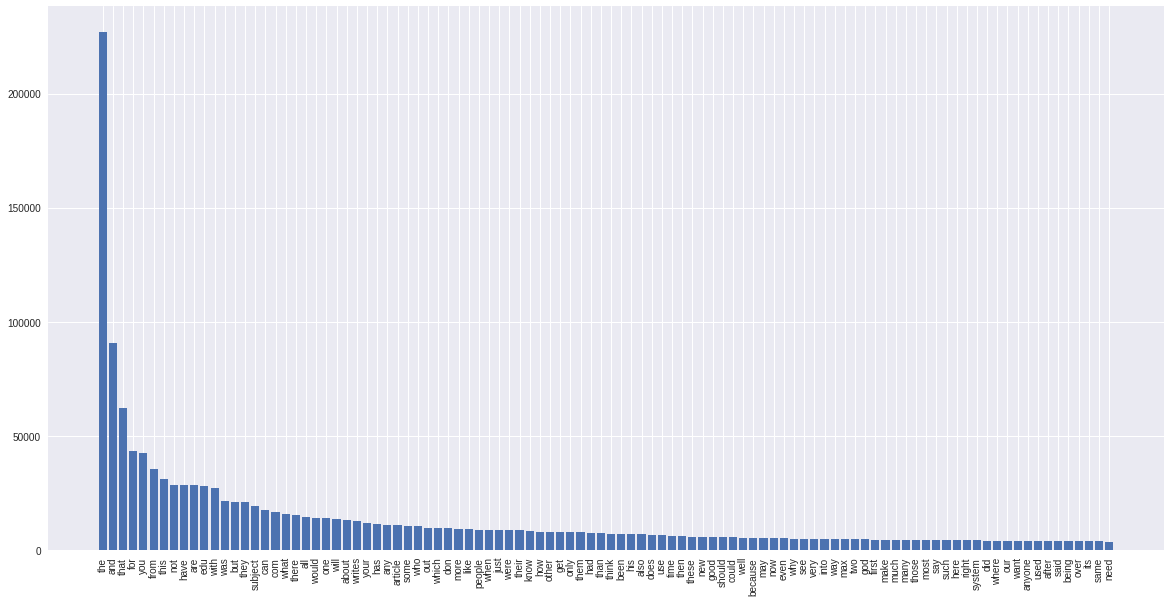

In [0]:
%matplotlib inline  

fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 1.2 Pre-processing to remove most and least frequent words

We can see that different words appear with different frequencies.

The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not mater much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value.

Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts: 

In [0]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


### 1.3 Bag-of-Words representation

The simplest way to represent a document $D$ as a vector $V$ would be to now count the relevant words in the document. 

For each document, make a vector of the count of each of the words in the vocabulary (excluding the words removed in the previous step - the "stopwords").

In [0]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

In [0]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

### 1.4 Document classification using Bag-of-Words after reducing the data using PCA with different no. of principal components

### It will take longer time then expected because of the large dataset, componets size is large and we are trying to classify using Knn

Computing accuracy for the bag-of-words features on the full train set:

In [0]:
components= [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
accuracies = []
for i in components:
  pca = PCA(n_components=i) #varying the components
  pca.fit(train_bow_set)  #fitting the training with pca model
  X_train = pca.transform(train_bow_set)
  X_test = pca.transform(test_bow_set)
  clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean') #Using Knn classifier with three nearest neighbours
  clf.fit(X_train, train_bow_labels)
  acc = clf.score(X_train, train_bow_labels)
  accuracies.append(acc)
  print('Accuracy with {} components of PCA is {}'.format(i,acc))

Accuracy with 2 components of PCA is 0.41794384159301934
Accuracy with 4 components of PCA is 0.443114442331357
Accuracy with 8 components of PCA is 0.5102360443002573
Accuracy with 16 components of PCA is 0.5813849423872917
Accuracy with 32 components of PCA is 0.6274191744042957
Accuracy with 64 components of PCA is 0.6509117350934109
Accuracy with 128 components of PCA is 0.6818436066674125
Accuracy with 256 components of PCA is 0.7102584181675803
Accuracy with 512 components of PCA is 0.7244658239176641
Accuracy with 1024 components of PCA is 0.7274303613379572
Accuracy with 2048 components of PCA is 0.7161874930081664
Accuracy with 4096 components of PCA is 0.7017004139165455


###Plotting the graph between number of components vs accuracies

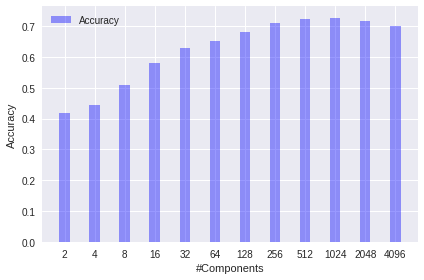

In [0]:
index = np.arange(len(accuracies))
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index , accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 #yerr=std_e1,
                 #error_kw=error_config,
                 label='Accuracy')
plt.xticks(index, components)
plt.xlabel("#Components")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

The decrease in accuracy after 1024 components is due to the noise in the data when ore components are added.

### Please answer the questions below to complete the experiment:




In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good, But Not Challenging for me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "test'\"" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook  { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 12001
Date of submission:  24 Mar 2019
Time of submission:  13:22:42
View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions
For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.
